# Import

In [171]:
from pandas import read_csv
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from pandas import concat

import numpy as np
import datetime

In [172]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [173]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')

train = read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                 header=0, names=['index','value', 'date'], index_col='index', parse_dates=True, squeeze=True)
# test = read_csv('your_train_series.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train['value'] = train['value'].astype(float)
train['date'] = train['date'].astype('datetime64')
train = train[train['value'] > 0.0]

train.head()

,value,date
index,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00


In [174]:
split_date = '1/1/2019 12:00:00 AM'
test  = train[split_date : ]
train = train[ : split_date]

test.head()

,value,date
index,,
2019-01-01 00:00:00,7297.073,2019-01-01 00:00:00
2019-01-01 01:00:00,6900.449,2019-01-01 01:00:00
2019-01-01 02:00:00,6869.606,2019-01-01 02:00:00
2019-01-01 03:00:00,6856.405,2019-01-01 03:00:00
2019-01-01 04:00:00,6853.338,2019-01-01 04:00:00


# Concatenate train and test series to plotting

In [175]:
train = train['value']
test = test['value']
series = concat([train, test], axis=0)
series

index
2000-01-01 00:00:00    2422.500
2000-01-01 01:00:00    2769.300
2000-01-01 02:00:00    3124.700
2000-01-01 03:00:00    3154.600
2000-01-01 04:00:00    3121.800
                         ...   
2021-01-30 20:00:00    7217.682
2021-01-30 21:00:00    7187.145
2021-01-30 22:00:00    6658.727
2021-01-30 23:00:00    6529.498
2021-01-31 00:00:00    6279.152
Name: value, Length: 184783, dtype: float64

# Prepare data

In [176]:
def persistence(last_ob, n_steps):
	return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]
# Number of multi-step
n_steps = 7
# Store multi-step forecasts
forecasts = list()
# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1
# Walk-forward validation
for i in range(n_forecasts):
	# Make a multi-step forecast
	last_ob = train[-1]
	yhat = persistence(last_ob, n_steps)
    # Store the multi-step forecast
	forecasts.append(yhat)
	# Add actual observation to train for the next loop
	obs = test[i]
	train.append(obs)

print(train[-10:])
print(forecasts[-10:])

[5867.007, 5772.947, 5531.001, 5426.944, 5570.198, 5702.289, 5645.473, 5910.213, 5967.413, 6164.76]
[[4856.806, 4856.806, 4856.806, 4856.806, 4856.806, 4856.806, 4856.806], [5867.007, 5867.007, 5867.007, 5867.007, 5867.007, 5867.007, 5867.007], [5772.947, 5772.947, 5772.947, 5772.947, 5772.947, 5772.947, 5772.947], [5531.001, 5531.001, 5531.001, 5531.001, 5531.001, 5531.001, 5531.001], [5426.944, 5426.944, 5426.944, 5426.944, 5426.944, 5426.944, 5426.944], [5570.198, 5570.198, 5570.198, 5570.198, 5570.198, 5570.198, 5570.198], [5702.289, 5702.289, 5702.289, 5702.289, 5702.289, 5702.289, 5702.289], [5645.473, 5645.473, 5645.473, 5645.473, 5645.473, 5645.473, 5645.473], [5910.213, 5910.213, 5910.213, 5910.213, 5910.213, 5910.213, 5910.213], [5967.413, 5967.413, 5967.413, 5967.413, 5967.413, 5967.413, 5967.413]]


# Evaluate the forecasts

In [177]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
 for i in range(n_steps):
    # Picking the values from multi-step forecasts
    ypred_ts = [forecast[i] for forecast in forecasts]
    # Sliding window on test series
    ytrue_ts = test[i:len(ypred_ts)+i]
    print(f"t+{(i+1)} RMSE: {sqrt(mean_squared_error(ytrue_ts, ypred_ts))}")


evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 409.5791668849234
t+2 RMSE: 702.2755963495919
t+3 RMSE: 930.6308875324014
t+4 RMSE: 1123.00293015266
t+5 RMSE: 1286.0373172871498
t+6 RMSE: 1424.0263617148444
t+7 RMSE: 1538.0858295930952


# Plot the forecasts

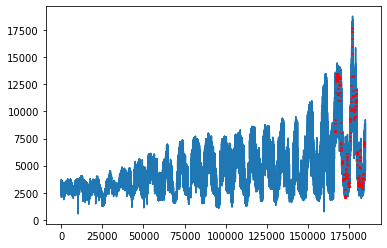

In [178]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
	# Plot the entire dataset in blue
	pyplot.plot(series)
	# Plot the forecasts in red
	for i in range(len(forecasts)):
        # Start offset for x-axis
		off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
		off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
		xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
		yaxis = [series[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# Show the final plot
	pyplot.show()


plot_forecasts(series, forecasts, test)